# cnot json for "wako"
超伝導量子コンピュータ"wako"用のcnot制約の設定(json)を生成するノートブックです。

nodeやedgeの操作を簡単に行うため、NetworkXを使います。

In [1]:
!pip install networkx[default]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## wakoでのcnot制約の仕様

wakoは8x8の格子状に量子ビットが並んでいるため、NetworkXの2d graphで表現しやすいです。

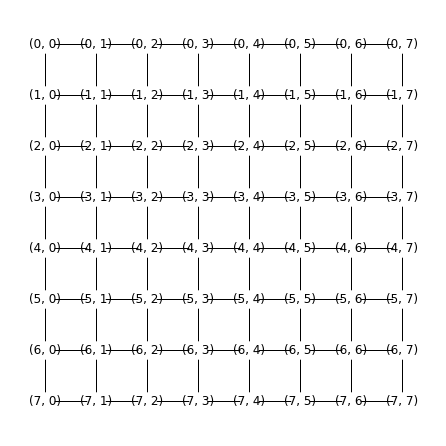

In [2]:
import networkx as nx
from matplotlib import pyplot as plt

G = nx.grid_2d_graph(8, 8)
plt.figure(figsize=(6, 6))
pos = {(x,y):(y,-x) for x, y in G.nodes()}
nx.draw(G,
        pos=pos, 
        node_color="white", 
        with_labels=True)

上記をベースに、wakoでは次の条件を満たす必要があります。

1. 量子ビットのインデックスは0-63までの連番になっている。
1. 次のような2x2の格子(小さな格子)をさらに4x4個並べる(大きな格子)ことで、8x8の格子を構成している。(n=0,...,15)
```
  4n   -- 4n+1
  |        |
  |        |
  4n+2 -- 4n+3
```
1. cnotの制御ビットはインデックスが{4n, 4n+3}の量子ビットで、対象ビットは{4n+1, 4n+2}の量子ビットになる。



NetworkXのノード名は量子ビットのインデックスにマッピングする必要があります。
```
(0, 0) -> 0
(0, 1) -> 1
(1, 0) -> 2
(1, 1) -> 3
```
また、NetworkXで可視化する際のデフォルトのレイアウトは人間には見づらいことも多いです。人間が見やすいようにノードを座標を決めて可視化する必要があります。
上記の図では`nx.draw`関数の引数`pos`で座標を指定しています。



## cnot制約の設定を生成するための関数

In [3]:
from typing import Dict
import json

import networkx as nx

def create_mapping_and_pos(
    small_lattice_rows: int,
    small_lattice_cols: int,
    large_lattice_rows: int,
    large_lattice_cols: int,
  ) -> Dict:
  """
  小さな格子の行数・列数と、大きな格子の行数・列数を指定して、mappingとposを生成する
  """
  mapping = dict()
  pos = dict()

  total_rows = small_lattice_rows * large_lattice_rows
  total_cols = small_lattice_cols * large_lattice_cols
  small_lattice_size = small_lattice_rows * small_lattice_cols

  for total_row_index in range(total_rows):
    for total_col_index in range(total_cols):
      # large_latticeの(row, col)と、small_latticeの(row, col)を求める
      large_row_index, small_row_index = divmod(total_row_index, small_lattice_rows)
      large_col_index, small_col_index = divmod(total_col_index, small_lattice_cols)

      # 各lattice毎のindexを求める
      large_lattice_index = large_row_index * large_lattice_cols + large_col_index
      small_lattice_index = small_row_index * small_lattice_cols + small_col_index

      # 全体のindexを求める
      total_index = large_lattice_index * small_lattice_size + small_lattice_index

      # mappingとposを求める
      mapping[(total_row_index, total_col_index)] = total_index
      pos[total_index] = (total_col_index, -total_row_index)

  return mapping, pos

def convert_to_digraph(G):
  """
  引数で指定されたグラフから、制御ビットが{4n, 4n+3}で、対象ビットが{4n+1, 4n+2}になる有向グラフを生成する。
  """
  ditected_G = nx.DiGraph()

  for edge in G.edges():
    if edge[0] % 4 == 0 or edge[0] % 4 == 3:
      ditected_G.add_edge(edge[0], edge[1])
    else:
      ditected_G.add_edge(edge[1], edge[0])

  return ditected_G

def dump(name, G, fp=None) -> None:
  """
  convert_to_digraph関数で生成した有向グラフから、cnot制約の設定を生成する。
  fpを指定すればそのファイルに出力し、未指定なら標準出力する。
  """
  cnot_constraint = dict()
  cnot_constraint["name"] = name

  qubits = []
  for node in G.nodes():
    qubits.append({"id": node})
  cnot_constraint["qubits"] = qubits

  couplings = []
  for edge in G.edges():
    couplings.append({"control": edge[0], "target": edge[1]})
  cnot_constraint["couplings"] = couplings

  if fp is None:
    print(json.dumps(cnot_constraint, indent=2))
  else:
    json.dump(cnot_constraint, fp, indent=2)

## wakoの設定を出力

まずは、8x8の格子を生成する。

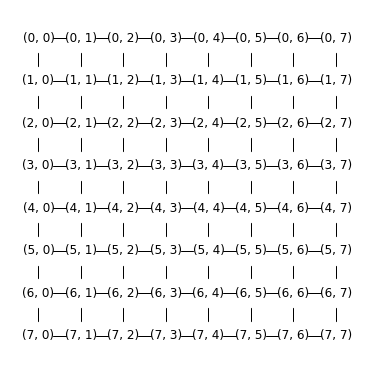

In [4]:
plt.figure(figsize=(5, 5))
G = nx.grid_2d_graph(8, 8)
pos = {(x,y):(y,-x) for x, y in G.nodes()}
nx.draw(G, pos=pos, node_color="white", with_labels=True, node_size=800)

`create_mapping_and_pos`関数を使って、量子ビットのインデックスを割り当てる。生成したグラフは変数`G`とする。

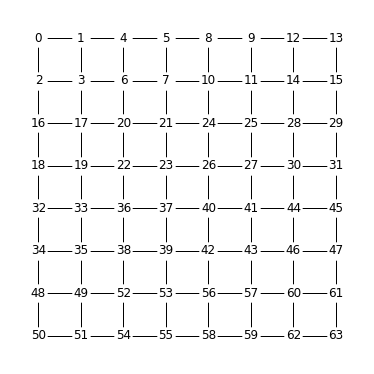

In [5]:
plt.figure(figsize=(5, 5))
mapping, pos = create_mapping_and_pos(2, 2, 4, 4)
G = nx.relabel_nodes(G, mapping)
nx.draw(G, pos=pos, node_color="white", with_labels=True)

`convert_to_digraph`関数を使って、cnotの向きを考慮した有向グラフを生成する。生成したグラフは変数`ditected_G`とする。

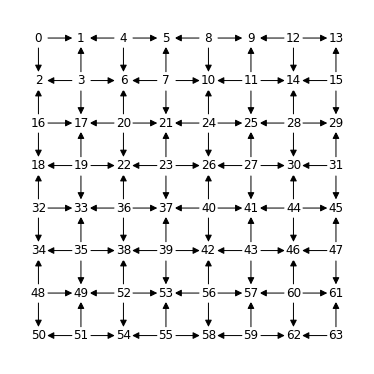

In [6]:
plt.figure(figsize=(5, 5))
ditected_G = convert_to_digraph(G)
nx.draw(ditected_G, pos=pos, font_color="black", node_color="white", edge_color="black", with_labels=True, arrowsize=14)

cnot制約の設定を標準出力する。

In [7]:
dump("wako", ditected_G)

{
  "name": "wako",
  "qubits": [
    {
      "id": 0
    },
    {
      "id": 2
    },
    {
      "id": 1
    },
    {
      "id": 3
    },
    {
      "id": 4
    },
    {
      "id": 6
    },
    {
      "id": 5
    },
    {
      "id": 7
    },
    {
      "id": 8
    },
    {
      "id": 10
    },
    {
      "id": 9
    },
    {
      "id": 11
    },
    {
      "id": 12
    },
    {
      "id": 14
    },
    {
      "id": 13
    },
    {
      "id": 15
    },
    {
      "id": 16
    },
    {
      "id": 17
    },
    {
      "id": 20
    },
    {
      "id": 21
    },
    {
      "id": 24
    },
    {
      "id": 25
    },
    {
      "id": 28
    },
    {
      "id": 29
    },
    {
      "id": 18
    },
    {
      "id": 19
    },
    {
      "id": 22
    },
    {
      "id": 23
    },
    {
      "id": 26
    },
    {
      "id": 27
    },
    {
      "id": 30
    },
    {
      "id": 31
    },
    {
      "id": 32
    },
    {
      "id": 33
    },
    {
      "id": 36
   

cnot制約の設定をwako.jsonに出力する。

In [8]:
dump("wako", ditected_G, open("wako.json", "w"))